In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv2

import torch
import torch.nn as nn
import torch.optim as optim
import random

import torchvision
import torchvision.utils
from torchvision.models import detection
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import dataset as data
import utils as utils
import pickle
import attackMethods as am

print(torch.__version__)
print(torch.cuda_version)
print(torchvision.__version__)

1.10.0+cu113
11.3
0.11.1+cu113


In [2]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

dataset = data.AdversarialDataset((640,640)) # todo: use resize to pull picture in batch

loss = am.lossObjectness


batch_size = 4

train_loader  = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)

#device = torch.device("cpu")
device = torch.device("cuda:0")
#'cuda:0' or 'cpu'

In [3]:
#train on pictures from dset (pictures with persons in personIndex list)

model.eval()
model = model.float().to(device)

patch = am.generatePatch()
patch = patch.to(device)
patch.requires_grad = True

TVCoeff = 0.00000001
GradRate = 0.05

#personIndex = []

epoches = 1

class StopExecution(Exception):
    def _render_traceback_(self):
        pass

for epoch in range(epoches):
    imageCounter = 0
    for image, label in train_loader:
        imageCounter += batch_size
        for k in range(5):
            cv2.imshow("patch", cv2.resize(data.TenToIm(patch.clone().detach().to(torch.device("cpu"))/255), (300,300)))

            attackedImage = []

            torch.cuda.empty_cache()

            for im in image:
                attackedImage.append(data.ImToTen(im).to(device))

            for attackedIm in attackedImage:
                attackedIm.requires_grad = True

            clearPredict = model(attackedImage)

            for i in range(len(attackedImage)):
                for l in label[i]:
                    attackedImage[i] = am.setPatch(attackedImage[i], patch, l, 0.2, device) 


            predict = model(attackedImage)

            costs = []

            for i in range(len(clearPredict)):
                cost = loss(clearPredict[i], predict[i])
                if cost == 0:
                    continue
                grad = torch.autograd.grad(cost, patch, retain_graph=False, create_graph=False,  allow_unused=True)[0]
                if grad != None:
                    patch = patch - GradRate*grad.sign()
                costs.append(cost.detach().cpu())
            print("ep:", epoch,"epoch_progress:", imageCounter/len(dataset), "loss:", np.mean(np.asarray(costs)))


            key = cv2.waitKey(1)
            if key & 0xFF == ord('q'):
                cv2.destroyAllWindows() 
                utils.SavePatch(patch.cpu(), "patch - new")
                raise StopExecution


g:\ДИПЛОМ\diplomfile\dataset.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(np.swapaxes(np.swapaxes(image, 0, 2),1,2)).float() / 255)
C:\Users\Skiv2\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


ep: 0 epoch_progress: 3.381605755492996e-05 loss: 1.1170648
ep: 0 epoch_progress: 3.381605755492996e-05 loss: 1.1212676
ep: 0 epoch_progress: 3.381605755492996e-05 loss: 1.1159205
ep: 0 epoch_progress: 3.381605755492996e-05 loss: 1.1161195
ep: 0 epoch_progress: 3.381605755492996e-05 loss: 1.1234626
ep: 0 epoch_progress: 6.763211510985992e-05 loss: 1.1095303
ep: 0 epoch_progress: 6.763211510985992e-05 loss: 1.1229693
ep: 0 epoch_progress: 6.763211510985992e-05 loss: 1.1506321
ep: 0 epoch_progress: 6.763211510985992e-05 loss: 1.1130959
ep: 0 epoch_progress: 6.763211510985992e-05 loss: 1.1432678
ep: 0 epoch_progress: 0.00010144817266478988 loss: 1.1129713
ep: 0 epoch_progress: 0.00010144817266478988 loss: 1.1254871
ep: 0 epoch_progress: 0.00010144817266478988 loss: 1.1356732
ep: 0 epoch_progress: 0.00010144817266478988 loss: 1.1356732
ep: 0 epoch_progress: 0.00010144817266478988 loss: 1.1356732
ep: 0 epoch_progress: 0.00013526423021971985 loss: 3.9940226
ep: 0 epoch_progress: 0.0001352642

C:\Users\Skiv2\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Skiv2\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ep: 0 epoch_progress: 0.0003381605755492996 loss: nan
ep: 0 epoch_progress: 0.0003381605755492996 loss: nan
ep: 0 epoch_progress: 0.0003381605755492996 loss: nan
ep: 0 epoch_progress: 0.0003381605755492996 loss: nan
ep: 0 epoch_progress: 0.0003381605755492996 loss: nan
ep: 0 epoch_progress: 0.00037197663310422957 loss: 1.1154308
ep: 0 epoch_progress: 0.00037197663310422957 loss: 1.1154308
ep: 0 epoch_progress: 0.00037197663310422957 loss: 1.1154308
ep: 0 epoch_progress: 0.00037197663310422957 loss: 1.1154308
ep: 0 epoch_progress: 0.00037197663310422957 loss: 1.1154308
ep: 0 epoch_progress: 0.0004057926906591595 loss: nan
ep: 0 epoch_progress: 0.0004057926906591595 loss: nan
ep: 0 epoch_progress: 0.0004057926906591595 loss: nan
ep: 0 epoch_progress: 0.0004057926906591595 loss: nan
ep: 0 epoch_progress: 0.0004057926906591595 loss: nan
ep: 0 epoch_progress: 0.00043960874821408945 loss: 1.1303496
ep: 0 epoch_progress: 0.00043960874821408945 loss: 1.1303496
ep: 0 epoch_progress: 0.000439608

StopExecution: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


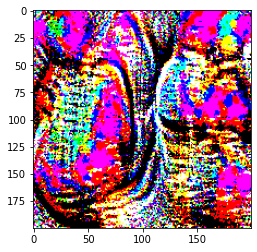

In [9]:
#torch.cuda.empty_cache()
#cv2.destroyAllWindows() 
utils.ShowPatch(patch.cpu())

In [8]:
#image, label = dataset[personIndex[7]]

In [8]:
patch = utils.LoadPatch("patch - new")

In [5]:
utils.SavePatch(patch.cpu(), "patch - new2")

In [24]:
with open('0_4784.pickle', 'wb') as f:
    pickle.dump(personIndex, f)

In [4]:
with open('0_4784.pickle', 'rb') as f:
    personIndex = pickle.load(f)

In [68]:
image, label = dataset[personIndex[7]]
patch = utils.TrainOneImage(model, loss, image, label, epoches=10)

ep: 0  loss: tensor(1.1819, grad_fn=<AddBackward0>)
ep: 1  loss: tensor(1.1061, grad_fn=<AddBackward0>)
ep: 2  loss: tensor(1.0346, grad_fn=<AddBackward0>)
ep: 3  loss: tensor(0.9632, grad_fn=<AddBackward0>)
ep: 4  loss: tensor(0.8850, grad_fn=<AddBackward0>)
ep: 5  loss: tensor(0.8303, grad_fn=<AddBackward0>)
ep: 6  loss: tensor(0.7588, grad_fn=<AddBackward0>)
ep: 7  loss: tensor(0.6875, grad_fn=<AddBackward0>)
ep: 8  loss: tensor(0.6162, grad_fn=<AddBackward0>)
ep: 9  loss: tensor(0.5449, grad_fn=<AddBackward0>)


In [23]:
for i in range(20):
    image, label = dataset[personIndex[i]]
    utils.CheckPatch(patch, image, label, model, device, loss)

Clear loss: tensor(1.1095, grad_fn=<MulBackward0>) Attacked loss: tensor(1.1095, grad_fn=<MulBackward0>)
Clear loss: tensor(1.2138, grad_fn=<MulBackward0>) Attacked loss: tensor(1.1075, grad_fn=<MulBackward0>)
Clear loss: tensor(1.1265, grad_fn=<MulBackward0>) Attacked loss: tensor(1.1043, grad_fn=<MulBackward0>)
Clear loss: tensor(1.1616, grad_fn=<MulBackward0>) Attacked loss: tensor(1.2186, grad_fn=<MulBackward0>)
Clear loss: tensor(1.1064, grad_fn=<MulBackward0>) Attacked loss: tensor(1.1702, grad_fn=<MulBackward0>)
Clear loss: tensor(1.8352, grad_fn=<MulBackward0>) Attacked loss: tensor(1.1531, grad_fn=<MulBackward0>)
Clear loss: tensor(1.4608, grad_fn=<MulBackward0>) Attacked loss: tensor(1.1437, grad_fn=<MulBackward0>)
Clear loss: tensor(1.1680, grad_fn=<MulBackward0>) Attacked loss: tensor(1.1739, grad_fn=<MulBackward0>)
Clear loss: tensor(1.1299, grad_fn=<MulBackward0>) Attacked loss: tensor(1.1785, grad_fn=<MulBackward0>)
Clear loss: tensor(1.6535, grad_fn=<MulBackward0>) Atta